<a href="https://colab.research.google.com/github/sayanghorui/samplecode/blob/master/IMDB_classification_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Collecting individual IMDB review into List of Strings and Processing Labels in a List

In [0]:
import os

In [0]:
imdb_dir = 'C:/Users/Sayan/Desktop/ML_datasets/aclImdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [0]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [0]:
import numpy as np
np.asarray(labels).shape
np.asarray(texts).shape

(25000,)

In [0]:
print(np.asarray(labels))

[0 0 0 ... 1 1 1]


### Tokenize the data

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download GLOVE embeddings and Pre-process it

In [0]:
glove_dir = 'C:/Users/Sayan/Desktop/ML_datasets/aclImdb/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Build Model

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Loading the Glove embeddings into the model

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Train and Evaluate the model

In [0]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

model.save_weights('C:/Users/Sayan/Desktop/ML_datasets/aclImdb/pre_trained_glove_model.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 2.0484 - acc: 0.4450 - val_loss: 0.6909 - val_acc: 0.5372
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5120 - acc: 0.8050 - val_loss: 0.7599 - val_acc: 0.5080
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4043 - acc: 0.8750 - val_loss: 0.7583 - val_acc: 0.5027
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3382 - acc: 0.9100 - val_loss: 0.8720 - val_acc: 0.5081
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3286 - acc: 0.8500 - val_loss: 0.7002 - val_acc: 0.5421
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1696 - acc: 0.9950 - val_loss: 0.7120 - val_acc: 0.5555
Epoch 7/10
200/200 [==============================] - 1s 4ms/ste

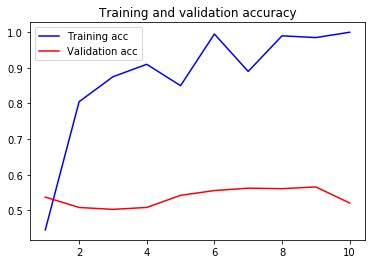

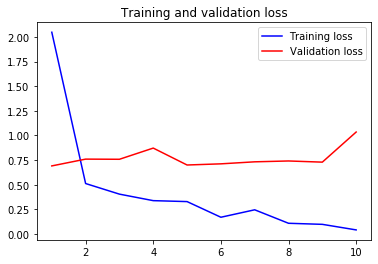

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Without loading pre-trained Word Embeddings

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 0.6920 - acc: 0.5450 - val_loss: 0.6940 - val_acc: 0.5023
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4639 - acc: 0.9750 - val_loss: 0.7070 - val_acc: 0.5056
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2470 - acc: 0.9800 - val_loss: 0.7162 - val_acc: 0.4999
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1103 - acc: 0.9950 - val_loss: 0.7279 - val_acc: 0.5021
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0522 - acc: 1.0000 - val_loss: 0.7270 - val_acc: 0.5078
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0263 - acc: 1.0000 - val_loss: 0.7449 - val_acc: 0.5107
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0146 - acc: 1.0000 - val_loss: 0.7439 - val_acc: 0.5085
Epoch 8/10
200/200 [========

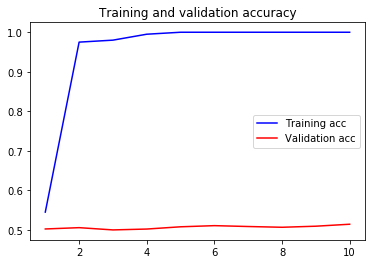

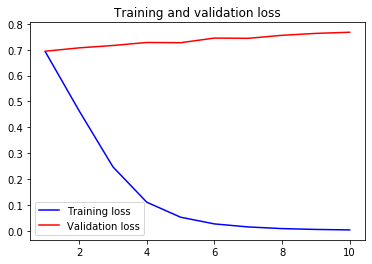

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate the model on test data

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [0]:
model.load_weights('C:/Users/Sayan/Desktop/ML_datasets/aclImdb/pre_trained_glove_model.h5')

In [0]:
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 2s 79us/step


[1.0194156882858276, 0.5274]